## 1) Setup & Data Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: copy from "/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch/netG.pth" to "/content/weights"

import shutil
import os

# Create the destination directory if it doesn't exist
os.makedirs("/content/weights", exist_ok=True)

shutil.copy("/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch/netG.pth", "/content/weights")


'/content/weights/netG.pth'

In [ ]:
# Create the destination directory if it doesn't exist
os.makedirs("/content/ColoredMangaMain", exist_ok=True)

shutil.copy("/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/data/ColoredMangaMain.zip", "/content/") # 26+ GB

#unzip file
!unzip -q "/content/ColoredMangaMain.zip" -d "/content/ColoredMangaMain"

In [17]:
import os
import glob
import random
import functools
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import to_rgba
from skimage.color import rgb2lab, lab2rgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Locate images inside the unzipped folder.
# Adjust this path if your images are in subfolders, etc.
all_image_paths = glob.glob("/content/ColoredMangaMain/**/*.png", recursive=True)
all_image_paths += glob.glob("/content/ColoredMangaMain/**/*.jpg", recursive=True)
all_image_paths += glob.glob("/content/ColoredMangaMain/**/*.jpeg", recursive=True)

print(f"Found {len(all_image_paths)} images.")

Using device: cuda
Found 36285 images.


In [ ]:
np.random.seed(42)
np.random.shuffle(all_image_paths)
N = min(len(all_image_paths), 15000)
all_image_paths = all_image_paths[:N]
train_size = int(0.8 * len(all_image_paths))
train_paths = all_image_paths[:train_size]
val_paths   = all_image_paths[train_size:]

print(f"Train set size: {len(train_paths)}")
print(f"Val set size:   {len(val_paths)}")

Train set size: 12000
Val set size:   3000


## 2) Dataset Definition

In [ ]:
class MangaColorizationHintDataset(Dataset):
    """
    Produces (input_4ch, (l_diff, a, b)):
      input_4ch = [ base_L, hint_L, hint_A, hint_B ] in shape (4,H,W),
      label      = (l_diff, a, b).
    Where 'hint_L,A,B' are mostly nonzero in "colorful" spots.
    """
    def __init__(self, image_paths, threshold=100, img_size=256,
                 max_hints=5, color_threshold=0.3):
        self.image_paths = image_paths
        self.threshold = threshold
        self.img_size = img_size
        self.max_hints = max_hints
        self.color_threshold = color_threshold

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        bgr_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if bgr_img is None:
            raise ValueError(f"Error loading image at: {img_path}")

        # 1) Resize
        if self.img_size is not None:
            bgr_img = cv2.resize(bgr_img, (self.img_size, self.img_size))

        # 2) Gray => base_L (thresholded)
        gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
        base_L = np.where(gray_img >= self.threshold, 255, gray_img).astype(np.float32)

        # 3) L_diff
        l_diff = (gray_img.astype(np.float32) - base_L).astype(np.float32)

        # 4) Convert to Lab
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        lab_img = rgb2lab(rgb_img)  # L:[0..100], A,B ~[-128..127]
        L_lab = lab_img[..., 0]
        A_lab = lab_img[..., 1]
        B_lab = lab_img[..., 2]

        # 5) Normalize
        base_L_norm = base_L / 255.0             # [0..1]
        l_diff_norm = l_diff / 255.0            # [-1..1]
        L_lab_norm  = L_lab / 100.0             # [0..1]
        A_lab_norm  = A_lab / 128.0             # [-1..1]
        B_lab_norm  = B_lab / 128.0             # [-1..1]

        # 6) Convert to torch ground truths
        t_l_diff = torch.tensor(l_diff_norm, dtype=torch.float32).unsqueeze(0)
        t_a      = torch.tensor(A_lab_norm,  dtype=torch.float32).unsqueeze(0)
        t_b      = torch.tensor(B_lab_norm,  dtype=torch.float32).unsqueeze(0)

        # 7) Build hint channels
        H, W = gray_img.shape
        hint_L = np.zeros((H,W), dtype=np.float32)
        hint_A = np.zeros((H,W), dtype=np.float32)
        hint_B = np.zeros((H,W), dtype=np.float32)

        # 8) Identify "colorful" pixels: sqrt(A^2 + B^2) > color_threshold
        ab_magnitude = np.sqrt(A_lab_norm**2 + B_lab_norm**2)
        mag_flat = ab_magnitude.flatten()
        colorful_indices = np.where(mag_flat > self.color_threshold)[0]

        # 9) Randomly pick up to max_hints from the "colorful" set
        if len(colorful_indices) > 0:
            num_hints = np.random.randint(0, self.max_hints+1)
            num_hints = min(num_hints, len(colorful_indices))
            chosen = np.random.choice(colorful_indices, size=num_hints, replace=False)

            for cidx in chosen:
                y = cidx // W
                x = cidx % W
                # Place ground-truth L,A,B => user is "choosing" them
                hint_L[y,x] = L_lab_norm[y,x]
                hint_A[y,x] = A_lab_norm[y,x]
                hint_B[y,x] = B_lab_norm[y,x]

        # 10) Convert base_L to torch
        t_base_L = torch.tensor(base_L_norm, dtype=torch.float32).unsqueeze(0)
        t_hint_L = torch.tensor(hint_L,      dtype=torch.float32).unsqueeze(0)
        t_hint_A = torch.tensor(hint_A,      dtype=torch.float32).unsqueeze(0)
        t_hint_B = torch.tensor(hint_B,      dtype=torch.float32).unsqueeze(0)

        # 11) Combine => shape [4,H,W]
        input_4ch = torch.cat([t_base_L, t_hint_L, t_hint_A, t_hint_B], dim=0)

        return input_4ch, (t_l_diff, t_a, t_b)

#### Create datasets/dataloaders

In [ ]:
train_dataset = MangaColorizationHintDataset(
    train_paths, threshold=100, img_size=512,
    max_hints=5, color_threshold=0.3
)
val_dataset   = MangaColorizationHintDataset(
    val_paths,   threshold=100, img_size=512,
    max_hints=5, color_threshold=0.3
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4)

print("Train/Val loader ready.")

Train/Val loader ready.


## 3) Model Definition (U-Net)

In [ ]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if isinstance(norm_layer, functools.partial):
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        if input_nc is None:
            input_nc = outer_nc

        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up   = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up   = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up   = [uprelu, upconv, upnorm]
            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [ ]:
class UnetGeneratorHints(nn.Module):
    """
    input_nc=4 => [ base_L, hint_L, hint_A, hint_B ]
    output_nc=3 => [ L_diff, A, B ]
    """
    def __init__(self, input_nc=4, output_nc=3, num_downs=8, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGeneratorHints, self).__init__()
        # construct unet structure from innermost to outermost
        unet_block = UnetSkipConnectionBlock(
            ngf * 8, ngf * 8, input_nc=None,
            submodule=None, norm_layer=norm_layer, innermost=True
        )
        # add intermediate layers
        for _ in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(
                ngf * 8, ngf * 8, input_nc=None,
                submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout
            )
        # reduce filters
        unet_block = UnetSkipConnectionBlock(
            ngf * 4, ngf * 8, input_nc=None,
            submodule=unet_block, norm_layer=norm_layer
        )
        unet_block = UnetSkipConnectionBlock(
            ngf * 2, ngf * 4, input_nc=None,
            submodule=unet_block, norm_layer=norm_layer
        )
        unet_block = UnetSkipConnectionBlock(
            ngf, ngf * 2, input_nc=None,
            submodule=unet_block, norm_layer=norm_layer
        )
        # outermost
        self.model = UnetSkipConnectionBlock(
            output_nc, ngf, input_nc=input_nc,
            submodule=unet_block, outermost=True,
            norm_layer=norm_layer
        )

    def forward(self, x):
        return self.model(x)

## 4) Partial Weight Loading (not used in this case)

In [ ]:
def create_pretrained_unet_for_manga(
    anime2sketch_ckpt="weights/netG.pth",
    norm_layer=None,
    num_downs=8,
    ngf=64,
    use_dropout=False
):
    """
    Create a new U-Net generator with input=1, output=3
    and partially load from the anime2sketch checkpoint (which is 3->1).
    """
    if norm_layer is None:
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)

    # 1 input channel -> 3 output channels
    net_manga = UnetGenerator(
        input_nc=1,
        output_nc=3,
        num_downs=num_downs,
        ngf=ngf,
        norm_layer=norm_layer,
        use_dropout=use_dropout
    )

    # Load the checkpoint
    ckpt = torch.load(anime2sketch_ckpt, map_location="cpu")
    # Remove any 'module.' prefixes
    for key in list(ckpt.keys()):
        if "module." in key:
            ckpt[key.replace("module.", "")] = ckpt[key]
            del ckpt[key]

    # Only load matching layers
    model_dict = net_manga.state_dict()
    pretrained_dict = {}
    for k, v in ckpt.items():
        if k in model_dict and model_dict[k].shape == v.shape:
            pretrained_dict[k] = v

    model_dict.update(pretrained_dict)
    net_manga.load_state_dict(model_dict)

    return net_manga

## 6) Training + Validation + Visualization

In [20]:
def denormalize_lab_tensors(base_L, pred_l_diff, pred_a, pred_b):
    """
    final_L = base_L + l_diff, scale to [0..100].
    A,B in [-1..1] => scaled to ~[-128..127].
    Convert to RGB via lab2rgb.
    """
    L_final = (base_L + pred_l_diff).clamp(0,1)  # shape [H,W]
    A_lab   = pred_a * 128.0
    B_lab   = pred_b * 128.0
    L_lab   = L_final * 100.0

    lab_img = torch.stack([L_lab, A_lab, B_lab], dim=-1).cpu().numpy()
    rgb_img = lab2rgb(lab_img.astype(np.float64))
    return rgb_img


# def visualize_predictions(model, loader, num_samples=2):
#     """
#     Show a few predictions vs. ground truth from the loader
#     """
#     model.eval()
#     with torch.no_grad():
#         for (x_4ch, (gt_l_diff, gt_a, gt_b)) in loader:
#             x_4ch    = x_4ch.to(device)
#             gt_l_diff= gt_l_diff.to(device)
#             gt_a     = gt_a.to(device)
#             gt_b     = gt_b.to(device)

#             out = model(x_4ch)
#             pred_l_diff = out[:,0:1,:,:]
#             pred_a      = out[:,1:2,:,:]
#             pred_b      = out[:,2:3,:,:]

#             B = x_4ch.size(0)
#             nshow = min(B, num_samples)
#             for i in range(nshow):
#                 # base_L is channel 0
#                 base_L_i = x_4ch[i, 0, :, :].detach()
#                 hint_L_i = x_4ch[i, 1, :, :].detach()
#                 hint_A_i = x_4ch[i, 2, :, :].detach()
#                 hint_B_i = x_4ch[i, 3, :, :].detach()

#                 l_diff_i = pred_l_diff[i,0,:,:].detach()
#                 a_i      = pred_a[i,0,:,:].detach()
#                 b_i      = pred_b[i,0,:,:].detach()

#                 # ground truth
#                 gt_ldiff_i= gt_l_diff[i,0,:,:].detach()
#                 gt_a_i    = gt_a[i,0,:,:].detach()
#                 gt_b_i    = gt_b[i,0,:,:].detach()

#                 # predicted
#                 pred_rgb = denormalize_lab_tensors(base_L_i, l_diff_i, a_i, b_i)
#                 # ground truth
#                 gt_rgb   = denormalize_lab_tensors(base_L_i, gt_ldiff_i, gt_a_i, gt_b_i)

#                 fig, axes = plt.subplots(1,4, figsize=(16,4))
#                 # base_L
#                 axes[0].imshow(base_L_i.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
#                 axes[0].set_title("Base L (thresholded)")

#                 # visualize hint magnitude
#                 hint_magnitude = torch.sqrt(hint_L_i**2 + hint_A_i**2 + hint_B_i**2).cpu().numpy()
#                 axes[1].imshow(hint_magnitude, cmap='hot')
#                 axes[1].set_title("Hint Magnitude")

#                 axes[2].imshow(pred_rgb)
#                 axes[2].set_title("Prediction (RGB)")

#                 axes[3].imshow(gt_rgb)
#                 axes[3].set_title("Ground Truth (RGB)")

#                 for ax in axes:
#                     ax.axis('off')
#                 plt.show()

#             break
#     model.train()

def visualize_predictions(model, loader, num_samples=2, max_hint_viz=10):
    """
    Show a few predictions vs. ground truth from the loader,
    with user-hint points visualized on top of the grayscale image.

    Args:
        model: your trained UnetGeneratorHints (input_nc=4, output_nc=3)
        loader: a DataLoader with batches of (x_4ch, (gt_l_diff, gt_a, gt_b))
        num_samples (int): how many images from the batch to visualize
        max_hint_viz (int): maximum number of hint pixels to visualize (arrows)
    """
    model.eval()
    with torch.no_grad():
        for (x_4ch, (gt_l_diff, gt_a, gt_b)) in loader:
            # Move data to GPU if available
            x_4ch    = x_4ch.to(model.device if hasattr(model, 'device') else torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            gt_l_diff= gt_l_diff.to(x_4ch.device)
            gt_a     = gt_a.to(x_4ch.device)
            gt_b     = gt_b.to(x_4ch.device)

            # Forward pass
            out = model(x_4ch)
            pred_l_diff = out[:,0:1,:,:]
            pred_a      = out[:,1:2,:,:]
            pred_b      = out[:,2:3,:,:]

            B = x_4ch.size(0)
            nshow = min(B, num_samples)

            # Loop over images to display
            for i in range(nshow):
                # (1) base_L is channel 0
                base_L_i = x_4ch[i, 0, :, :].detach()  # shape (H,W)
                # (2) hint channels
                hint_L_i = x_4ch[i, 1, :, :].detach()
                hint_A_i = x_4ch[i, 2, :, :].detach()
                hint_B_i = x_4ch[i, 3, :, :].detach()

                # (3) predicted
                l_diff_i = pred_l_diff[i,0,:,:].detach()
                a_i      = pred_a[i,0,:,:].detach()
                b_i      = pred_b[i,0,:,:].detach()

                # (4) ground truth
                gt_ldiff_i= gt_l_diff[i,0,:,:].detach()
                gt_a_i    = gt_a[i,0,:,:].detach()
                gt_b_i    = gt_b[i,0,:,:].detach()

                # Convert predictions to RGB
                pred_rgb = denormalize_lab_tensors(base_L_i, l_diff_i, a_i, b_i)
                # Convert ground truth to RGB
                gt_rgb   = denormalize_lab_tensors(base_L_i, gt_ldiff_i, gt_a_i, gt_b_i)

                #######################################################
                # Plotting
                #######################################################
                fig, axes = plt.subplots(1,4, figsize=(16,4))
                # (a) base_L
                axes[0].imshow(base_L_i.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                axes[0].set_title("Base L (thresholded)")

                # (b) We'll overlay hint points on top of this same base L
                #     so let's copy that for an overlay
                ax1 = axes[1]
                ax1.imshow(base_L_i.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                ax1.set_title("Base L + hints")

                # We’ll find up to max_hint_viz pixels where hint != 0
                # hint magnitude = sqrt(hint_L^2 + hint_A^2 + hint_B^2)
                hint_mag = (hint_L_i**2 + hint_A_i**2 + hint_B_i**2).flatten()
                # nonzero = indices of all hint pixels
                nonzero_indices = (hint_mag > 1e-8).nonzero().cpu().numpy()
                # random sample up to max_hint_viz
                if len(nonzero_indices) > max_hint_viz:
                    chosen = np.random.choice(nonzero_indices.reshape(-1), size=max_hint_viz, replace=False)
                else:
                    chosen = nonzero_indices.reshape(-1)

                # Plot each chosen hint pixel
                H, W = hint_L_i.shape
                for cidx in chosen:
                    # map cidx back to (y,x)
                    y = cidx // W
                    x = cidx % W

                    # read that hint L,A,B
                    userL = hint_L_i[y,x].item()
                    userA = hint_A_i[y,x].item()
                    userB = hint_B_i[y,x].item()

                    # Convert to an RGB color for display
                    # userL in [0..1] => *100, userA,B in [-1..1] => *128
                    L_ = userL * 100
                    A_ = userA * 128
                    B_ = userB * 128
                    lab_val = np.array([[[L_, A_, B_]]], dtype=np.float64)
                    rgb_val = lab2rgb(lab_val)[0,0,:]  # shape (3,)

                    # We'll scatter a circle at (x,y)
                    ax1.scatter(x, y, c=[rgb_val], s=80, edgecolors='black', linewidths=1.0)
                    # Add an arrow from that point to some offset
                    # e.g. (x+10,y)
                    ax1.annotate(
                        "",
                        xy=(x, y),
                        xytext=(x+10, y),
                        arrowprops=dict(arrowstyle="->", color=rgb_val, linewidth=2)
                    )
                    # Possibly add text label with color background
                    ax1.text(
                        x+12, y, "hint",
                        color="black", fontsize=8,
                        bbox=dict(facecolor=rgb_val, alpha=0.9)
                    )

                # (c) predicted
                axes[2].imshow(pred_rgb)
                axes[2].set_title("Prediction (RGB)")

                # (d) ground truth
                axes[3].imshow(gt_rgb)
                axes[3].set_title("Ground Truth (RGB)")

                for ax in axes:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

            break  # only visualize one batch
    model.train()


def run_validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        for (x_4ch, (gt_l_diff, gt_a, gt_b)) in loader:
            x_4ch    = x_4ch.to(device)
            gt_l_diff= gt_l_diff.to(device)
            gt_a     = gt_a.to(device)
            gt_b     = gt_b.to(device)

            out = model(x_4ch)
            pred_l_diff = out[:,0:1,:,:]
            pred_a      = out[:,1:2,:,:]
            pred_b      = out[:,2:3,:,:]

            loss_l_diff = criterion(pred_l_diff, gt_l_diff)
            loss_a      = criterion(pred_a, gt_a)
            loss_b      = criterion(pred_b, gt_b)
            loss = loss_l_diff + loss_a + loss_b

            batch_size = x_4ch.size(0)
            val_loss += loss.item() * batch_size
            total    += batch_size
    model.train()
    return val_loss / total

In [ ]:
net_hints = UnetGeneratorHints(
    input_nc=4,   # baseL + L,A,B hints
    output_nc=3,  # L_diff, A, B
    num_downs=8,
    ngf=64,
    norm_layer=functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False),
    use_dropout=False
).to(device)

optimizer = torch.optim.Adam(net_hints.parameters(), lr=1e-4)
criterion = nn.L1Loss()

In [ ]:
num_epochs = 20
print_every = 2  # visualize every 2 epochs

for epoch in range(num_epochs):
    net_hints.train()
    running_loss = 0.0
    total_samps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for (x_4ch, (gt_l_diff, gt_a, gt_b)) in pbar:
        x_4ch    = x_4ch.to(device)
        gt_l_diff= gt_l_diff.to(device)
        gt_a     = gt_a.to(device)
        gt_b     = gt_b.to(device)

        optimizer.zero_grad()
        out = net_hints(x_4ch)
        pred_l_diff = out[:,0:1,:,:]
        pred_a      = out[:,1:2,:,:]
        pred_b      = out[:,2:3,:,:]

        loss_l_diff = criterion(pred_l_diff, gt_l_diff)
        loss_a      = criterion(pred_a, gt_a)
        loss_b      = criterion(pred_b, gt_b)
        loss = loss_l_diff + loss_a + loss_b

        loss.backward()
        optimizer.step()

        batch_size = x_4ch.size(0)
        running_loss += loss.item() * batch_size
        total_samps  += batch_size
        avg_loss = running_loss / total_samps
        pbar.set_postfix({"loss": f"{avg_loss:.4f}"})

    # end of epoch
    train_epoch_loss = running_loss / total_samps
    val_epoch_loss = run_validation(net_hints, val_loader, criterion)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

    # visualization
    if (epoch+1) % print_every == 0:
        visualize_predictions(net_hints, val_loader, num_samples=2)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
save_path = "/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch_userhint_colorization/anime2sketch_hinted_finetuned.pth"
model_dir = os.path.dirname(save_path)
os.makedirs(model_dir, exist_ok=True)
torch.save(net_hints, save_path)
print("Finished training! Model saved to:", save_path)

Finished training! Model saved to: /content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch_userhint_colorization/anime2sketch_hinted_finetuned.pth


## Train 10 more epochs

In [15]:
num_epochs = 10
print_every = 2

for epoch in range(num_epochs):
    net_hints.train()
    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for (x_4ch, (gt_l_diff, gt_a, gt_b)) in pbar:
        x_4ch    = x_4ch.to(device)
        gt_l_diff= gt_l_diff.to(device)
        gt_a     = gt_a.to(device)
        gt_b     = gt_b.to(device)

        optimizer.zero_grad()
        out = net_hints(x_4ch)
        pred_l_diff = out[:,0:1,:,:]
        pred_a      = out[:,1:2,:,:]
        pred_b      = out[:,2:3,:,:]

        loss_l_diff = criterion(pred_l_diff, gt_l_diff)
        loss_a      = criterion(pred_a, gt_a)
        loss_b      = criterion(pred_b, gt_b)
        loss = loss_l_diff + loss_a + loss_b

        loss.backward()
        optimizer.step()

        batch_size = x_4ch.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size
        pbar.set_postfix({"loss": f"{running_loss / total_samples:.4f}"})

    train_epoch_loss = running_loss / total_samples
    val_epoch_loss   = run_validation(net_hints, val_loader, criterion)
    print(f"[Epoch {epoch+1}/{num_epochs}]"
          f" Train Loss: {train_epoch_loss:.4f}"
          f" | Val Loss: {val_epoch_loss:.4f}")

    if (epoch+1) % print_every == 0:
        visualize_predictions(net_hints, val_loader, num_samples=2)

print("Training complete!")

Output hidden; open in https://colab.research.google.com to view.

In [16]:
save_path = "/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch_userhint_colorization/anime2sketch_hinted_finetuned30.pth"
model_dir = os.path.dirname(save_path)
os.makedirs(model_dir, exist_ok=True)
torch.save(net_hints, save_path)
print("Finished training! Model saved to:", save_path)

Finished training! Model saved to: /content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch_userhint_colorization/anime2sketch_hinted_finetuned30.pth


## Train fo 1 more epoch with proper visualization

Epoch 1/1: 100%|██████████| 750/750 [02:51<00:00,  4.38it/s, loss=0.1268]


[Epoch 1/1] Train Loss: 0.1268 | Val Loss: 0.1737


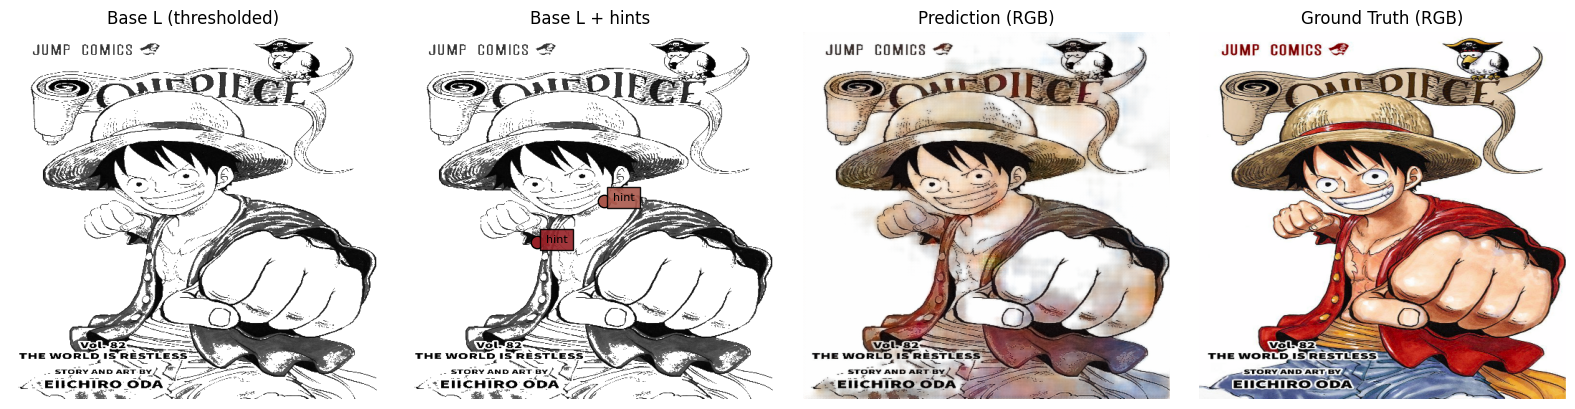

<ipython-input-20-d8fae34e0a7f>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(lab_img.astype(np.float64))


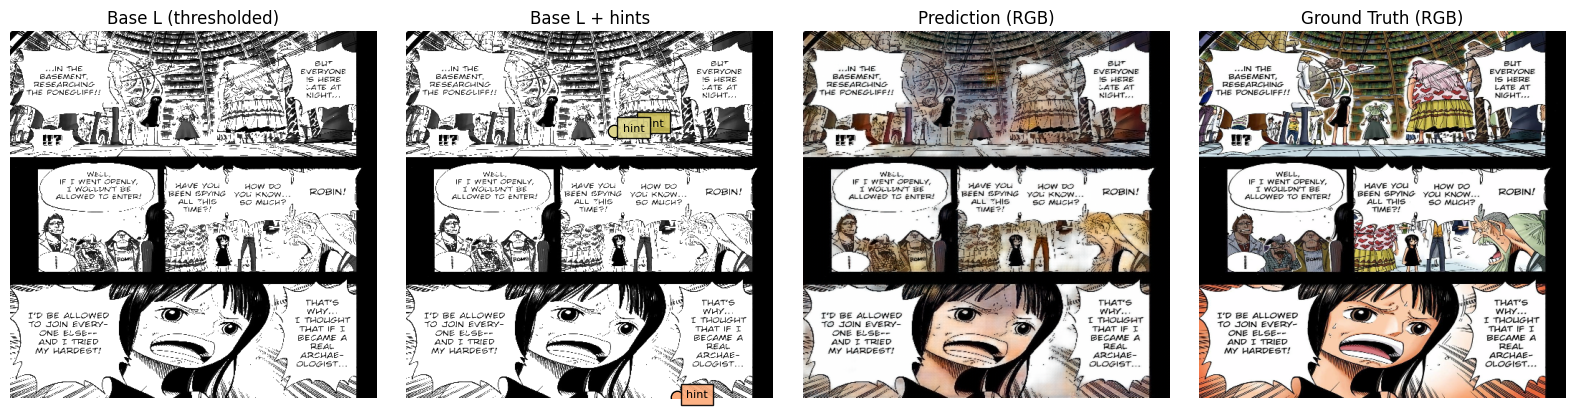

Training complete!


In [21]:
num_epochs = 1
print_every = 1

for epoch in range(num_epochs):
    net_hints.train()
    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for (x_4ch, (gt_l_diff, gt_a, gt_b)) in pbar:
        x_4ch    = x_4ch.to(device)
        gt_l_diff= gt_l_diff.to(device)
        gt_a     = gt_a.to(device)
        gt_b     = gt_b.to(device)

        optimizer.zero_grad()
        out = net_hints(x_4ch)
        pred_l_diff = out[:,0:1,:,:]
        pred_a      = out[:,1:2,:,:]
        pred_b      = out[:,2:3,:,:]

        loss_l_diff = criterion(pred_l_diff, gt_l_diff)
        loss_a      = criterion(pred_a, gt_a)
        loss_b      = criterion(pred_b, gt_b)
        loss = loss_l_diff + loss_a + loss_b

        loss.backward()
        optimizer.step()

        batch_size = x_4ch.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size
        pbar.set_postfix({"loss": f"{running_loss / total_samples:.4f}"})

    train_epoch_loss = running_loss / total_samples
    val_epoch_loss   = run_validation(net_hints, val_loader, criterion)
    print(f"[Epoch {epoch+1}/{num_epochs}]"
          f" Train Loss: {train_epoch_loss:.4f}"
          f" | Val Loss: {val_epoch_loss:.4f}")

    if (epoch+1) % print_every == 0:
        visualize_predictions(net_hints, val_loader, num_samples=2)

print("Training complete!")

In [ ]:
save_path = "/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/Anime2Sketch_userhint_colorization/anime2sketch_hinted_finetuned31.pth"
model_dir = os.path.dirname(save_path)
os.makedirs(model_dir, exist_ok=True)
torch.save(net_hints, save_path)
print("Finished training! Model saved to:", save_path)

## 7) Inference Function

In [22]:
def colorize_with_user_hint(
    model,
    base_image_path,
    user_hints,
    threshold=100,
    img_size=256,
    device=device,
    visualize=True
):
    """
    colorize_with_user_hint:
      - model: your trained net_hints
      - base_image_path: path to an image file
      - user_hints: list of (y, x, L, A, B) in normalized range,
                    e.g. L in [0..1], A,B in [-1..1].
      - threshold: for base_L
      - img_size: resizing
      - visualize: if True, shows a figure with:
          (left) grayscale + user hints (arrows with color patches)
          (right) final colorized output
    Returns a colorized RGB numpy array.
    """
    model.eval()
    with torch.no_grad():
        # 1) load & resize
        bgr_img = cv2.imread(base_image_path, cv2.IMREAD_COLOR)
        if bgr_img is None:
            raise ValueError(f"Could not load {base_image_path}")

        if img_size is not None:
            bgr_img = cv2.resize(bgr_img, (img_size, img_size))

        gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
        base_L = np.where(gray_img >= threshold, 255, gray_img).astype(np.float32)
        base_L_norm = base_L / 255.0  # [0..1]

        # 2) Prepare 3 hint channels => all zeros
        H, W = gray_img.shape
        hint_L = np.zeros((H,W), dtype=np.float32)
        hint_A = np.zeros((H,W), dtype=np.float32)
        hint_B = np.zeros((H,W), dtype=np.float32)

        # 3) Place user hints
        #    user_hints is a list of (y, x, L, A, B) in normalized range
        for (y, x, userL, userA, userB) in user_hints:
            # clamp if needed
            if 0 <= y < H and 0 <= x < W:
                hint_L[y,x] = userL
                hint_A[y,x] = userA
                hint_B[y,x] = userB

        # 4) Torchify => shape [4,H,W]
        t_base_L = torch.tensor(base_L_norm, dtype=torch.float32).unsqueeze(0)
        t_hint_L = torch.tensor(hint_L,      dtype=torch.float32).unsqueeze(0)
        t_hint_A = torch.tensor(hint_A,      dtype=torch.float32).unsqueeze(0)
        t_hint_B = torch.tensor(hint_B,      dtype=torch.float32).unsqueeze(0)

        inp_4ch = torch.cat([t_base_L, t_hint_L, t_hint_A, t_hint_B], dim=0).unsqueeze(0).to(device)

        # 5) forward pass
        out = model(inp_4ch)
        pred_l_diff = out[:,0:1,:,:]
        pred_a      = out[:,1:2,:,:]
        pred_b      = out[:,2:3,:,:]

        # 6) Convert back to final RGB
        base_L_i = t_base_L[0,:,:]  # shape [H,W]
        colorized_rgb = denormalize_lab_tensors(
            base_L_i, pred_l_diff[0,0,:,:],
            pred_a[0,0,:,:], pred_b[0,0,:,:]
        )

    # 7) Optionally visualize hints + final color
    if visualize:
        fig, axes = plt.subplots(1,2, figsize=(12,5))
        # left: grayscale + arrows for user hints
        axes[0].imshow(base_L_norm, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title("Base L with user hints")

        # draw arrows or markers
        for (y, x, userL, userA, userB) in user_hints:
            if 0 <= y < H and 0 <= x < W:
                # Convert (L,A,B) to an RGB color patch
                #  L in [0..1] => *100, A,B => *128
                L_ = userL * 100.0
                A_ = userA * 128.0
                B_ = userB * 128.0
                lab_val = np.array([[[L_, A_, B_]]], dtype=np.float64)
                rgb_val = lab2rgb(lab_val)[0,0,:]

                # We'll place a small arrow or annotation
                # A simple approach: place a circle (scatter)
                # and an arrow annotation with a color background
                axes[0].scatter(x, y, c=[rgb_val], s=80, edgecolors='black', linewidths=1.0)
                axes[0].annotate(
                    "",
                    xy=(x, y),
                    xytext=(x+20, y),  # offset 20 px to the right
                    arrowprops=dict(arrowstyle="->", color=rgb_val, linewidth=2),
                )
                # We can also add a text label with color background
                axes[0].text(
                    x+25, y, "hint",
                    color="black",
                    fontsize=8,
                    bbox=dict(facecolor=rgb_val, alpha=0.9)
                )

        axes[0].axis('off')

        # right: final color
        axes[1].imshow(colorized_rgb)
        axes[1].set_title("Colorized result")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    return colorized_rgb

In [ ]:
    # Then colorize a test image with user hints:
    # user_hints = [(y, x, L, A, B), ...], all in normalized range
    # For instance, let's say we place a bright pink hint at (50, 80)
    # user picks L=0.8, A=0.7, B=0.7 => that might be a pinkish color
    # colorize_with_user_hint(net_hints, "/content/test.png", user_hints, 100, 256)

# # Suppose you have an image "manga_test.png" of size ~ 512x512
# # user picks a color for pixel (y=100,x=50),
# # let's say user picks L=0.8, A=-0.5, B=0.7 (some pinkish color)

# test_image_path = "/content/test_images/Bleach v1-063.jpg"
# hints = [
#     (100, 50, 0.8, -0.5, 0.7),  # (y, x, L, A, B) in normalized range
# ]
# res_rgb = colorize_with_user_hint(net_hints, test_image_path, hints, threshold=100, img_size=512)
# plt.imshow(res_rgb)
# plt.axis('off')
# plt.show()